# Семинар 11

# Субградиентный метод с переключениями

In [2]:
import numpy as np
import sklearn.preprocessing as skprep

import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [3]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

Найти проекцию точки $y$ на множетсво $Q$

$$\min_{x \in Q} \|x-y\|_2^2$$

## 1. Субградиентный метод с переключеними


Задача:

\begin{align*}
& \min_{x\in Q} f(x)\\
\text{s.t. } & g(x)\leq 0
\end{align*}

где $Q$ - выпуклое множество, $f:Q \rightarrow \mathbb{R}, g:Q \rightarrow \mathbb{R}$ - выпуклые функции.

Если $g(x_k)\leq \varepsilon$, то делаем шаг по $f$:

$$x_{k+1} =  \text{proj}_{x\in Q} \left(x_{k} - h_f \nabla f(x_k)\right)$$

иначе

$$x_{k+1} = \text{proj}_{x\in Q} \left(x_{k} - h_g \nabla g(x_k)\right)$$


In [4]:
class SubgradMethod:
    def __init__(self, h_f, h_g, scale=False, return_history=True, name=None):
        self.name = name
        self.return_history = return_history
        self.history = []
        self.h_f = h_f
        self.h_g = h_g
        self.scale = scale
        self.I = []
        self.J = []
    
    def solve(self, x0, f, subgradf, g, subgradg, proj, eps=1e-9, tol=1e-3, max_iter=10000):
        x = x0.copy()
        self.history = [(x, time.time())]
        h_f = self.h_f
        h_g = self.h_g
        for i in range(max_iter):
            if g(x) < eps:
                if self.scale:
                    alpha = h_f / (len(self.I) + 1)
                else:
                    alpha = h_f
                x = proj(x - alpha * subgradf(x))
                self.I.append(i)
            else:
                if self.scale:
                    alpha = h_g / (len(self.I) + 1)
                else:
                    alpha = h_g
                x = proj(x - alpha * subgradg(x))
                self.J.append(i)
            self.history.append((x, time.time()))
        return x

## 2. Эксперименты



### 2.1. Эксперименты: QP


Задача:

\begin{align*}
& \min_{x\in B_1(0)} \frac{1}{2}\|Ax-b\|^2\\
\text{s.t. } & Cx\leq d
\end{align*}

где $A\in\mathbb{R}^{m\times n}, C\in\mathbb{R}^{p\times n}$.

$$Cx\leq d \leftrightarrow g(x)\leq 0$$

$$g(x)=\max_{i=\overline{1,p}}(c_i^\top x - d_i)$$

$$\nabla g(x) = c_{i^*}, i^* = \arg\max_i (c_i^\top x - d_i)$$

In [6]:
class ProblemQP:
    """
    Problem
        1/2 ||Ax-b||^2 -> min_x
        s.t. Cx <= d,
             x \in B_1(0)
    """
    def __init__(self, A, b, C, d):
        self.A = A
        self.b = b
        self.C = C
        self.d = d
    
    def f(self, x):
        A, b = self.A, self.b
        return 1/2 * np.linalg.norm(A @ x - b)**2

    def gradf(self, x):
        A, b = self.A, self.b
        return A.T @ (A @ x - b)

    def g(self, x):
        C, d = self.C, self.d
        return C @ x - d
    
    def g_max(self, x, with_index=False):
        g_val = self.g(x)
        ind = np.argmax(g_val)
        if with_index:
            return g_val[ind], ind
        else:
            return g_val[ind]
        
    def subgradg_max(self, x):
        g_val = self.g(x)
        ind = np.argmax(g_val)
        return self.C[ind]
    
    def proj(self, x):
        normx = np.linalg.norm(x)
        if normx > 1:
            return x/normx
        else:
            return x

#### p =1

In [7]:
np.random.seed(1)
m, p, n = 100, 1, 1000

A = np.random.randn(m, n)
b = np.random.randn(m)
C = np.random.randn(p, n)
d = np.random.randn(p)
problem =ProblemQP(A, b, C, d)

In [8]:
num_iter = 200
x0 = np.zeros(n)
problem.g_max(x0)

0.7591050682681105

In [9]:
method = SubgradMethod(h_f=1e-3, h_g=1e-3)
x = method.solve(x0, problem.f, problem.gradf, problem.g_max, problem.subgradg_max, problem.proj, max_iter=num_iter)
problem.g_max(x), np.linalg.norm(x), problem.f(x)

(-0.3401783576550036, 0.28616746031369106, 2.414490223029668e-30)

In [11]:
%matplotlib inline
plt.rc("text", usetex=True)
fig, ax = plt.subplots(1, 2, figsize=(25, 5))

hist = [problem.f(x) for x, _ in method.history]
ax[1].semilogy(range(1, len(hist) + 1), hist)
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Function Value")
ax[1].grid()

hist = [problem.g_max(x) for x, _ in method.history]
ax[0].plot(range(1, len(hist) + 1), hist)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("$\max(Cx-d)$")
ax[0].grid()

plt.legend(loc="best", fontsize=24)

No handles with labels found to put in legend.


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fcb6a7c45f0> (for post_execute):


RuntimeError: ignored

RuntimeError: ignored

<Figure size 1800x360 with 2 Axes>

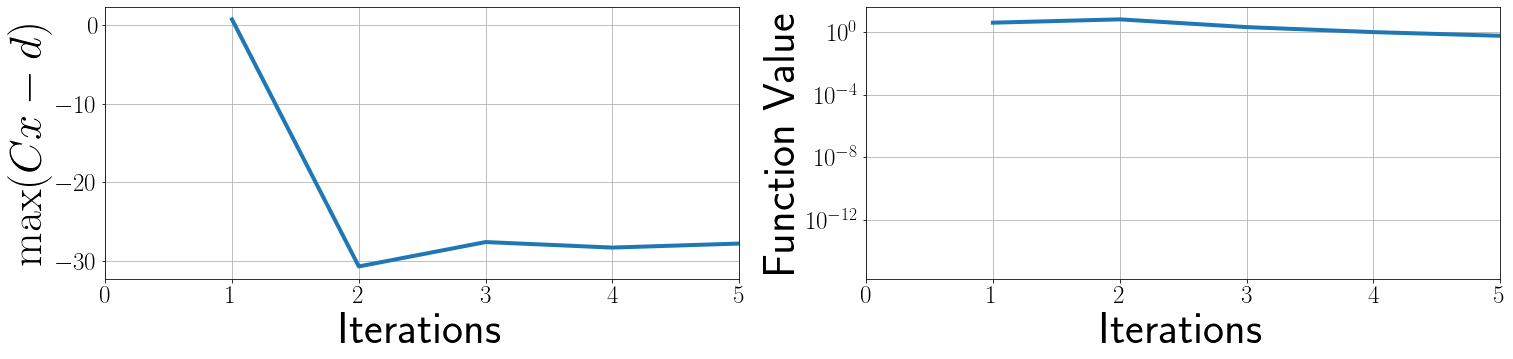

In [ ]:
%matplotlib inline
plt.rc("text", usetex=True)
fig, ax = plt.subplots(1, 2, figsize=(25, 5))

hist = [problem.f(x) for x, _ in method.history]
ax[1].semilogy(range(1, len(hist) + 1), hist)
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Function Value")
ax[1].grid()
ax[1].set_xlim(0,5)

hist = [problem.g_max(x) for x, _ in method.history]
ax[0].plot(range(1, len(hist) + 1), hist)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("$\max(Cx-d)$")
ax[0].set_xlim(0,5)
ax[0].grid()

#### p =300

In [ ]:
np.random.seed(1)
m, p, n = 100, 500, 1000

A = np.random.randn(m, n)
b = np.random.randn(m)
C = np.random.randn(p, n)
d = np.random.randn(p)
problem =ProblemQP(A, b, C, d)

In [ ]:
num_iter = 1500
x0 = np.zeros(n)
problem.g_max(x0)

2.9404209796809972

In [ ]:
method = SubgradMethod(h_f=1e-3, h_g=1e-3)
x = method.solve(x0, problem.f, problem.gradf, problem.g_max, problem.subgradg_max, problem.proj, max_iter=num_iter)
problem.g_max(x), np.linalg.norm(x), problem.f(x)

(-0.0009987902356660694, 1.0, 1.851849607868406e-15)

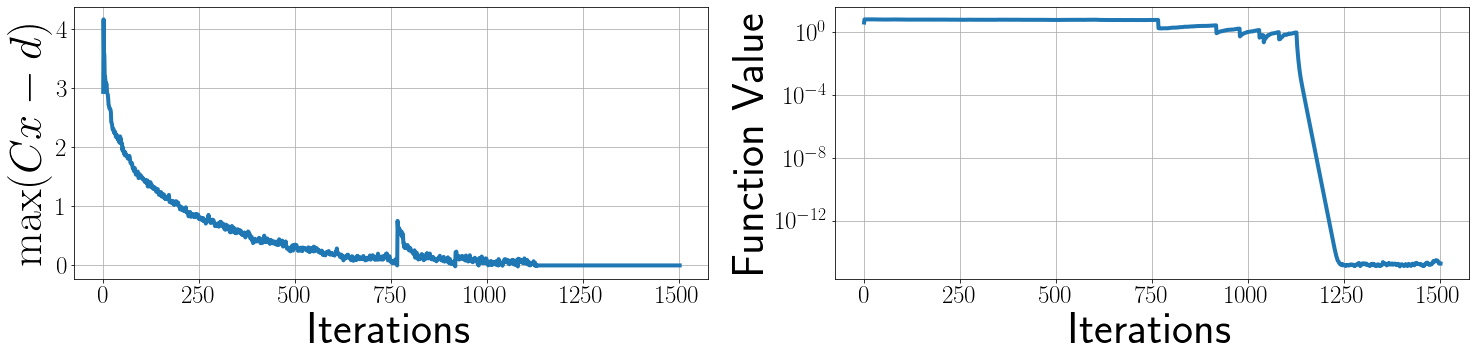

In [ ]:
%matplotlib inline
plt.rc("text", usetex=True)
fig, ax = plt.subplots(1, 2, figsize=(25, 5))

hist = [problem.f(x) for x, _ in method.history]
ax[1].semilogy(range(1, len(hist) + 1), hist)
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Function Value")
ax[1].grid()

hist = [problem.g_max(x) for x, _ in method.history]
ax[0].plot(range(1, len(hist) + 1), hist)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("$\max(Cx-d)$")
ax[0].grid()

### 2.1. Эксперименты: $\ell_1$ minimization


Задача:

\begin{align*}
& \min_{x\in B_1(0)} \|Ax-b\|_1\\
\text{s.t. } & Cx\leq d
\end{align*}

где $A\in\mathbb{R}^{m\times n}, C\in\mathbb{R}^{p\times n}$.

In [ ]:
class Probleml1(ProblemQP):
    """
    Problem
        1/2 ||Ax-b||_1 -> min_x
        s.t. Cx <= d,
             x \in B_1(0)
    """
    def __init__(self, A, b, C, d):
        self.A = A
        self.b = b
        self.C = C
        self.d = d
    
    def f(self, x):
        A, b = self.A, self.b
        return 1/2 * np.linalg.norm(A @ x - b, ord=1)

    def gradf(self, x):
        A, b = self.A, self.b
        return A.T @ np.sign(A @ x - b)

#### p =300

In [ ]:
np.random.seed(1)
m, p, n = 100, 500, 1000

A = np.random.randn(m, n)
b = np.random.randn(m)
C = np.random.randn(p, n)
d = np.random.randn(p)
problem = Probleml1(A, b, C, d)

In [ ]:
num_iter = 30000
x0 = np.zeros(n)
problem.g_max(x0)

2.9404209796809972

In [ ]:
method = SubgradMethod(h_f=1e-6, h_g=1e-3)
x = method.solve(x0, problem.f, problem.gradf, problem.g_max, problem.subgradg_max, problem.proj, max_iter=num_iter)
problem.g_max(x), np.linalg.norm(x), problem.f(x)

(-0.011519592038779614, 1.0, 0.03257717153244842)

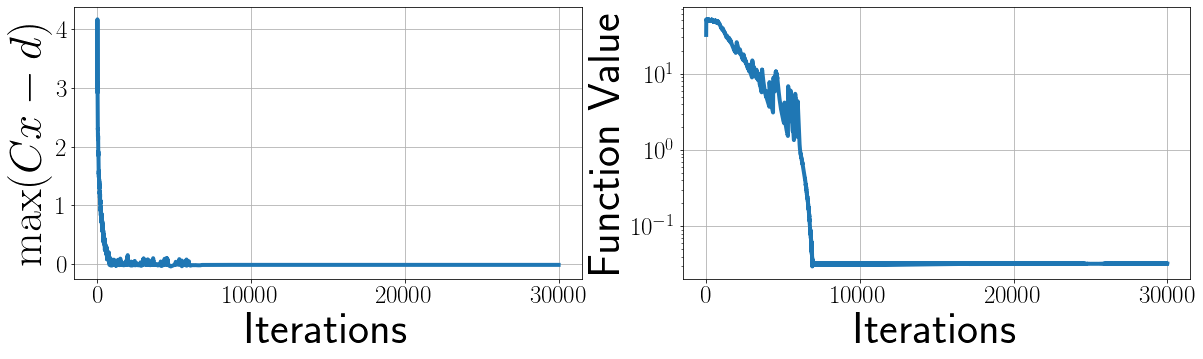

In [ ]:
%matplotlib inline
plt.rc("text", usetex=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

hist = [problem.f(x) for x, _ in method.history]
ax[1].semilogy(range(1, len(hist) + 1), hist)
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Function Value")
ax[1].grid()

hist = [problem.g_max(x) for x, _ in method.history]
ax[0].plot(range(1, len(hist) + 1), hist)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("$\max(Cx-d)$")
ax[0].grid()

In [ ]:
method = SubgradMethod(h_f=1e-3, h_g=1e-3, scale=True)
x = method.solve(x0, problem.f, problem.gradf, problem.g_max, problem.subgradg_max, problem.proj, max_iter=num_iter)
problem.g_max(x), np.linalg.norm(x), problem.f(x)

(-0.01188571235138236, 0.9999999999999999, 0.0006382313715222396)

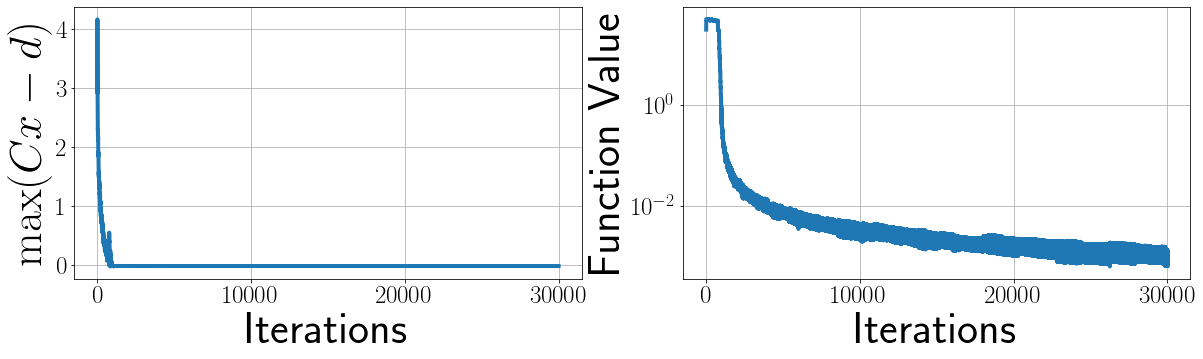

In [ ]:
%matplotlib inline
plt.rc("text", usetex=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

hist = [problem.f(x) for x, _ in method.history]
ax[1].semilogy(range(1, len(hist) + 1), hist)
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Function Value")
ax[1].grid()

hist = [problem.g_max(x) for x, _ in method.history]
ax[0].plot(range(1, len(hist) + 1), hist)
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("$\max(Cx-d)$")
ax[0].grid()

## Summary

1. Множество простой структуры
2. Проекция
3. Метод проекции градиента
4. Метод условного градиента
5. Proximal method
6. Proximal map and its property
7. Proximal gradient method and its acceleration
8. Lasso application